<a href="https://colab.research.google.com/github/arsh-datascience/Data-Science-and-Machine-Learning-Projects/blob/main/_stock_return_prediction_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Current directory: /content
Files in data/: ['MSFT.csv', 'symbols_valid_meta.csv', 'AAPL.csv', 'GOOGL.csv', 'NVDA.csv', 'AMZN.csv', 'QQQ.csv']

TEST METRICS
                 MAE      RMSE   SignAcc
ElasticNet  0.029168  0.042261  0.451613
RF          0.028356  0.041424  0.580645
GB          0.031872  0.043093  0.596774
Ensemble    0.029501  0.042162  0.435484


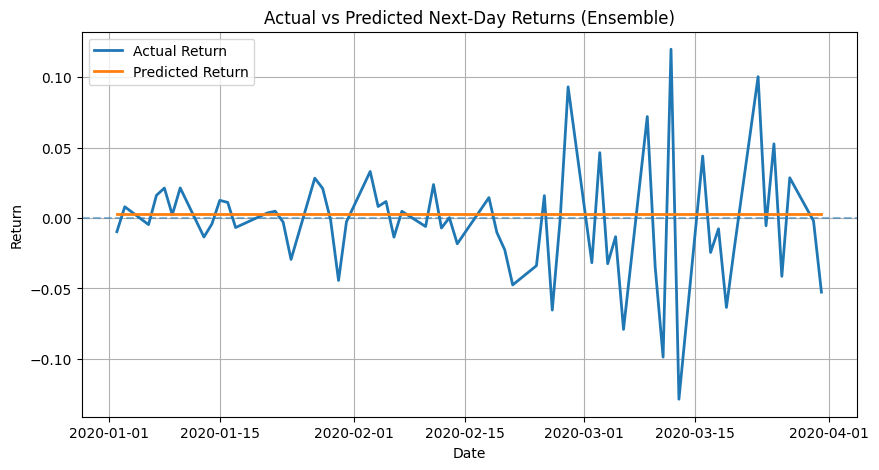

,Date,predicted_return,signal
3869,2020-01-02,0.002751,BUY
3870,2020-01-03,0.002751,BUY
3871,2020-01-06,0.002751,BUY
3872,2020-01-07,0.002751,BUY
3873,2020-01-08,0.002751,BUY
3874,2020-01-09,0.002751,BUY
3875,2020-01-10,0.002751,BUY
3876,2020-01-13,0.002751,BUY
3877,2020-01-14,0.002751,BUY
3878,2020-01-15,0.002751,BUY


In [ ]:

import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm


print("Current directory:", os.getcwd())
print("Files in data/:", os.listdir("data"))


target = "AAPL"
market = "QQQ"
peers = ["MSFT", "AMZN", "GOOGL", "NVDA"]

def load_stock(ticker):
    path = f"data/{ticker}.csv"
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} NOT FOUND")

    df = pd.read_csv(path)

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date")


    df = df[["Date", "Adj Close"]]
    df.rename(columns={"Adj Close": ticker}, inplace=True)

    return df

dfs = [load_stock(t) for t in [target, market] + peers]
df = reduce(lambda x, y: pd.merge(x, y, on="Date", how="inner"), dfs)


for col in [target, market] + peers:
    df[f"r_{col}"] = df[col].pct_change()

df["y_next"] = df[f"r_{target}"].shift(-1)
df["price_t"] = df[target]
df.dropna(inplace=True)


for lag in range(1, 6):
    df[f"lag_{lag}"] = df[f"r_{target}"].shift(lag)

df["mom20"] = df[f"r_{target}"].rolling(20).mean()
df["vol20"] = df[f"r_{target}"].rolling(20).std()

df["r_mkt"] = df[f"r_{market}"]
df["mkt_vol20"] = df["r_mkt"].rolling(20).std()

peer_returns = [f"r_{p}" for p in peers]
df["r_sector"] = df[peer_returns].mean(axis=1)
df["sec_vol20"] = df["r_sector"].rolling(20).std()


beta_mkt, beta_sec, resid = [], [], []

for i in range(len(df)):
    if i < 60:
        beta_mkt.append(np.nan)
        beta_sec.append(np.nan)
        resid.append(np.nan)
        continue

    y = df[f"r_{target}"].iloc[:i]
    X = df[["r_mkt", "r_sector"]].iloc[:i]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    beta_mkt.append(model.params["r_mkt"])
    beta_sec.append(model.params["r_sector"])
    resid.append(model.resid.iloc[-1])

df["beta_mkt"] = beta_mkt
df["beta_sec"] = beta_sec
df["idio_resid"] = resid
df.dropna(inplace=True)


df["year"] = df["Date"].dt.year

train = df[df["year"] == 2018]
val   = df[df["year"] == 2019]
test  = df[(df["Date"] >= "2020-01-01") & (df["Date"] <= "2020-03-31")]

features = [
    "lag_1","lag_2","lag_3","lag_4","lag_5",
    "mom20","vol20",
    "r_mkt","mkt_vol20",
    "r_sector","sec_vol20",
    "beta_mkt","beta_sec","idio_resid"
]

X_train, y_train = train[features], train["y_next"]
X_val, y_val     = val[features], val["y_next"]
X_test, y_test   = test[features], test["y_next"]


scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)


models = {
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "RF": RandomForestRegressor(n_estimators=200, random_state=42),
    "GB": GradientBoostingRegressor(random_state=42)
}

val_preds, test_preds = {}, {}

for name, model in models.items():
    if name == "ElasticNet":
        model.fit(X_train_s, y_train)
        val_preds[name] = model.predict(X_val_s)
        test_preds[name] = model.predict(X_test_s)
    else:
        model.fit(X_train, y_train)
        val_preds[name] = model.predict(X_val)
        test_preds[name] = model.predict(X_test)


Z_val  = np.column_stack(list(val_preds.values()))
Z_test = np.column_stack(list(test_preds.values()))

meta = Lasso(alpha=0.0005)
meta.fit(Z_val, y_val)

stack_test = meta.predict(Z_test)


def metrics(y, yhat):
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)

    return {
        "MAE": mean_absolute_error(y, yhat),
        "RMSE": rmse,
        "SignAcc": np.mean(np.sign(y) == np.sign(yhat))
    }


print("\nTEST METRICS")
print(pd.DataFrame({
    "ElasticNet": metrics(y_test, test_preds["ElasticNet"]),
    "RF": metrics(y_test, test_preds["RF"]),
    "GB": metrics(y_test, test_preds["GB"]),
    "Ensemble": metrics(y_test, stack_test)
}).T)

out = test[["Date"]].copy()
out["r_hat_next"] = stack_test
out["p_hat_next"] = test["price_t"] * (1 + stack_test)

out.head()

plt.figure(figsize=(10,5))
plt.plot(test["Date"], y_test.values, label="Actual Return", linewidth=2)
plt.plot(test["Date"], stack_test, label="Predicted Return", linewidth=2)
plt.axhline(0, linestyle="--", alpha=0.5)
plt.title("Actual vs Predicted Next-Day Returns (Ensemble)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


signals = test[["Date"]].copy()
signals["predicted_return"] = stack_test

signals["signal"] = np.where(
    signals["predicted_return"] > 0,
    "BUY",
    "SELL"
)

signals.head(10)
